# Business Filings in NYC

This notebook relies on data from the "Legally Operating Businesses" dataset posted on NYC Open data:

https://data.cityofnewyork.us/Business/Legally-Operating-Businesses/w7w3-xahh

It contains historical information on business filings in NYC including the business type and location. 

In [1]:
import urllib.request
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from fiona.crs import from_epsg
import matplotlib.pylab as plt
import numpy as np
import copy

In [2]:
business_filings = pd.read_csv('data/primary_source_data/business_filings.csv')
business_filings.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location
0,0959361-DCA,Business,03/31/2021,Active,04/25/1997,Garage,"PARKANLEX GARAGE COMPANY, LLC",NaN,115,E 75TH ST,...,108.0,4.0,1.04314e+06,1014100011,MN40,128.0,"Vehicle Spaces: 165, Bicycle Spaces: 17",-73.961625,40.772737,"(40.7727369020104, -73.96162515178469)"
1,1235988-DCA,Business,02/28/2021,Active,08/15/2006,Home Improvement Contractor,"JUNIOR'S IRONWORK & CONSTRUCTION, INC.",NaN,16927,LIBERTY AVE,...,412.0,27.0,4e+06,4102180032,QN61,444.0,NaN,-73.788915,40.703297,"(40.70329689832498, -73.78891454010119)"
2,1453298-DCA,Individual,05/31/2019,Active,01/07/2013,Locksmith,"RAO, GARY PETER",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2049399-DCA,Business,12/31/2020,Active,03/09/2017,Electronics Store,"CANAL ALARM DEVICES, INC.",NaN,387,CANAL ST,...,102.0,1.0,1.00294e+06,1002270004,MN24,47.0,NaN,-74.004791,40.721466,"(40.721465796925365, -74.00479091086221)"
4,2021443-DCA,Business,03/31/2021,Active,04/21/2015,Garage and Parking Lot,O & A PARKING GARAGE INC.,NaN,1100,FRANKLIN AVE,...,NaN,NaN,NaN,NaN,BX35,185.0,"Vehicle Spaces: 36, Bicycle Spaces: 10",NaN,NaN,NaN


In [3]:
# Remove rows for filings with Address Borough listed as "Outside NYC"
nyc_filings = business_filings[business_filings['Address Borough']!='Outside NYC']

In [4]:
# Drop "Location" column since it is improperly formatted
nyc_filings.drop(['Location'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
print("Total number of business filings in all of NYC: {}".format(nyc_filings.shape[0]))

Total number of business filings in all of NYC: 184145


## Grouping by date for NYC

In [6]:
# Convert creation date to datetime
nyc_filings['License Creation Date'] = pd.to_datetime(nyc_filings['License Creation Date'], \
                                                           format='%m/%d/%Y')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# All filings in NYC
filings_date_groups = nyc_filings.set_index('License Creation Date')
filings_date_groups.head()

,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,Secondary Address Street Name,...,Borough Code,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude
License Creation Date,,,,,,,,,,,,,,,,,,,,,
1997-04-25,0959361-DCA,Business,03/31/2021,Active,Garage,"PARKANLEX GARAGE COMPANY, LLC",NaN,115,E 75TH ST,NaN,...,1.0,108.0,4.0,1.04314e+06,1014100011,MN40,128.0,"Vehicle Spaces: 165, Bicycle Spaces: 17",-73.961625,40.772737
2006-08-15,1235988-DCA,Business,02/28/2021,Active,Home Improvement Contractor,"JUNIOR'S IRONWORK & CONSTRUCTION, INC.",NaN,16927,LIBERTY AVE,NaN,...,4.0,412.0,27.0,4e+06,4102180032,QN61,444.0,NaN,-73.788915,40.703297
2013-01-07,1453298-DCA,Individual,05/31/2019,Active,Locksmith,"RAO, GARY PETER",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-09,2049399-DCA,Business,12/31/2020,Active,Electronics Store,"CANAL ALARM DEVICES, INC.",NaN,387,CANAL ST,NaN,...,1.0,102.0,1.0,1.00294e+06,1002270004,MN24,47.0,NaN,-74.004791,40.721466
2015-04-21,2021443-DCA,Business,03/31/2021,Active,Garage and Parking Lot,O & A PARKING GARAGE INC.,NaN,1100,FRANKLIN AVE,NaN,...,2.0,NaN,NaN,NaN,NaN,BX35,185.0,"Vehicle Spaces: 36, Bicycle Spaces: 10",NaN,NaN


In [8]:
# Grouping all filings by the month of the creation date and taking the mean of each column
filings_count = filings_date_groups.resample('M').count()

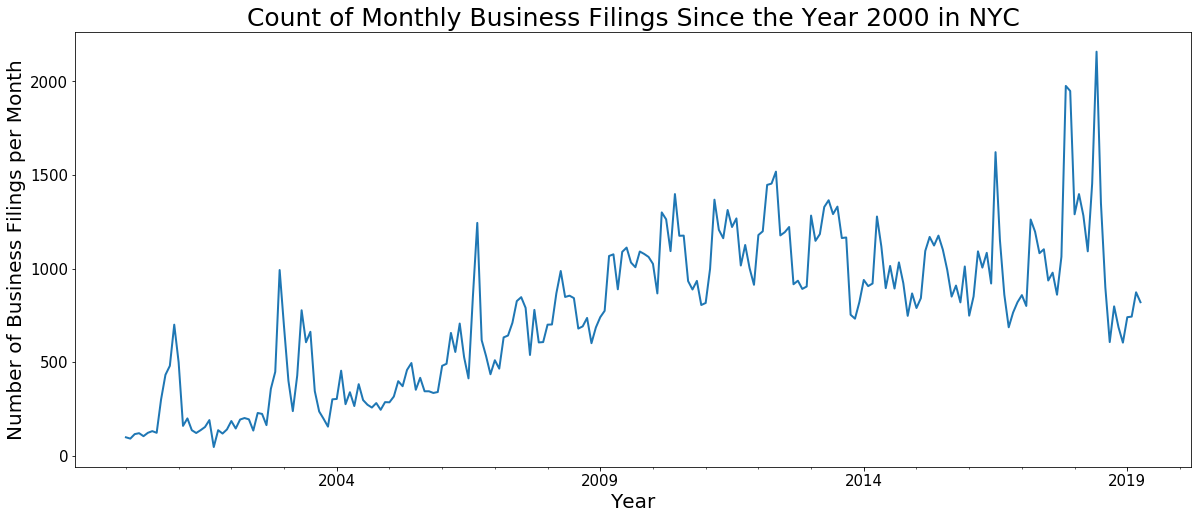

In [9]:
f, ax = plt.subplots(figsize=(20,8))
filings_count[filings_count.index.year>=2000]['DCA License Number'].plot(alpha=1,linewidth=2,ax=ax)
plt.title("Count of Monthly Business Filings Since the Year 2000 in NYC", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Business Filings per Month", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Business Filings for Brooklyn only

In [40]:
bk_df = nyc_filings[(nyc_filings['Address Borough']=='Brooklyn') | (nyc_filings['Address Borough']=='BROOKLYN')]

In [43]:
# All filings in NYC
bk_date_groups = bk_df.set_index('License Creation Date')
bk_date_groups.head()

,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,Secondary Address Street Name,...,Borough Code,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude
License Creation Date,,,,,,,,,,,,,,,,,,,,,
2018-05-24,2071799-DCA,Business,02/28/2019,Inactive,Home Improvement Contractor,148 HUA HONG INC,NaN,2011,W 13TH ST,NaN,...,3.0,311.0,47.0,3.1908e+06,3070930077,BK29,402.0,NaN,-73.984430,40.597747
2008-06-16,1289042-DCA,Business,12/31/2020,Active,Tobacco Retail Dealer,NEW STAR TOBACCO INC.,NaN,4524,5TH AVE,NaN,...,3.0,307.0,38.0,3.01157e+06,3007470045,BK32,80.0,NaN,-74.007600,40.647730
2013-07-11,1469166-DCA,Business,02/28/2021,Active,Home Improvement Contractor,DEPENDABLE GLASS & MIRROR CORP.,NaN,112,12TH ST,NaN,...,3.0,306.0,39.0,3.02307e+06,3010260018,BK37,117.0,NaN,-73.993829,40.670270
2017-06-30,2055200-DCA,Business,12/31/2020,Active,Electronics Store,"METRO SULZ, INC.",NaN,1450,ROCKAWAY PKWY,NaN,...,3.0,318.0,46.0,3e+06,3081840044,BK50,968.0,NaN,-73.901928,40.644774
2016-04-15,2036113-DCA,Business,03/31/2018,Inactive,Stoop Line Stand,YASMIN GROCERY CORP,NaN,1436,MYRTLE AVE,NaN,...,3.0,304.0,37.0,3.07568e+06,3033080013,BK77,433.0,"Product Category: Fruits, Vegetables, Soft Dri...",-73.917197,40.698918


In [44]:
# Grouping all filings by the month of the creation date and taking the mean of each column
bk_count = bk_date_groups.resample('M').count()

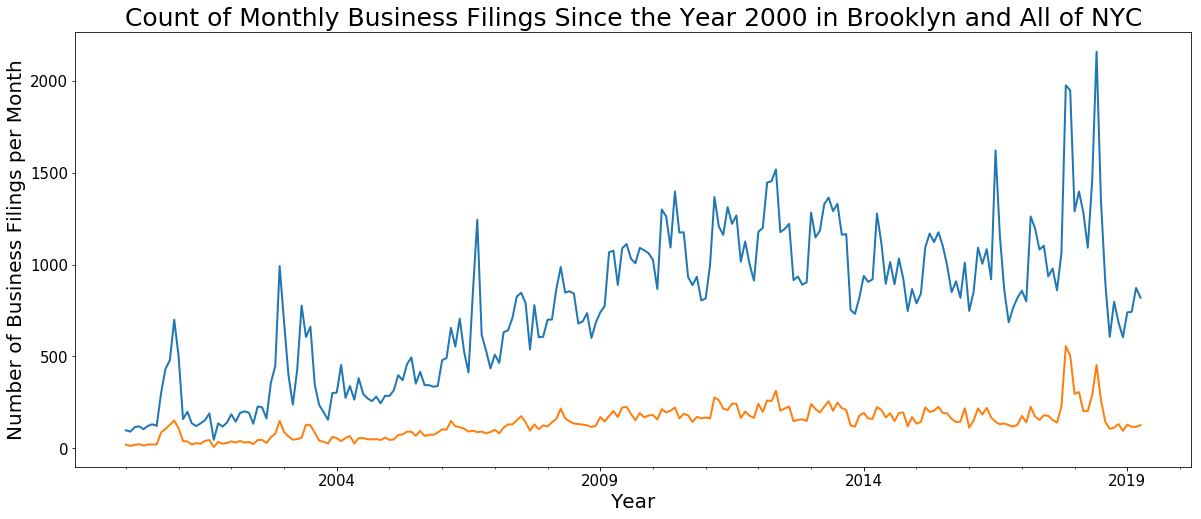

In [46]:
f, ax = plt.subplots(figsize=(20,8))
filings_count[filings_count.index.year>=2000]['DCA License Number'].plot(alpha=1,linewidth=2,ax=ax)
bk_count[bk_count.index.year>=2000]['DCA License Number'].plot(alpha=1,linewidth=2,ax=ax)
plt.title("Count of Monthly Business Filings Since the Year 2000 in Brooklyn and All of NYC", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Business Filings per Month", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Business Filings for Red Hook only

In [10]:
# Pull in the shapefile of the combined census tracts for Red Hook for spatial join
files = !ls data/created_data/rh_comb_tract
print(list(enumerate(files)))

[(0, 'rh_comb_tract.cpg'), (1, 'rh_comb_tract.dbf'), (2, 'rh_comb_tract.prj'), (3, 'rh_comb_tract.shp'), (4, 'rh_comb_tract.shx')]


In [11]:
# Census tracts for Red Hook
shp = files[3]
loc = 'data/created_data/rh_comb_tract/' + shp
rh_tracts = gpd.GeoDataFrame.from_file(loc)
rh_tracts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,geometry
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,POLYGON ((-74.00485241669628 40.68566813081066...


In [12]:
businesses_rh = copy.deepcopy(nyc_filings)

In [13]:
businesses_rh = businesses_rh[businesses_rh['Longitude'].notnull()]
businesses_rh['lonlat'] = list(zip(businesses_rh.Longitude, businesses_rh.Latitude))

In [14]:
businesses_rh = gpd.GeoDataFrame(businesses_rh)
businesses_rh.crs = from_epsg(4326)
businesses_rh['geometry'] = businesses_rh[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [15]:
# Match CRS
businesses_rh = businesses_rh.to_crs(epsg=4326)
rh_tracts = rh_tracts.to_crs(epsg=4326)

In [16]:
# Join with the Red Hook census tract to keep only business filings within the neighborhood
businesses_rh_sjoin = gpd.tools.sjoin(businesses_rh,rh_tracts)

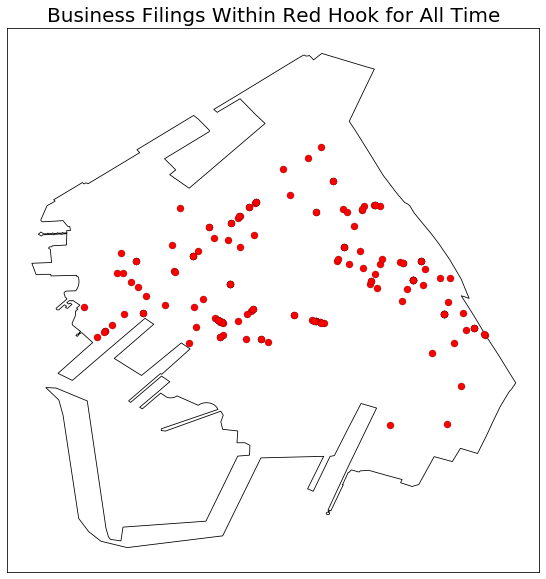

In [17]:
# Plot
f, ax = plt.subplots(figsize=(10,10))
rh_tracts.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
businesses_rh_sjoin.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=50)
plt.title("Business Filings Within Red Hook for All Time", fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
businesses_rh.

In [31]:
# All Red Hook filings
rh_date_groups = businesses_rh_sjoin.set_index('License Creation Date')
rh_date_groups.head()

,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,Secondary Address Street Name,...,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng
License Creation Date,,,,,,,,,,,,,,,,,,,,,
2010-11-09,1376498-DCA,Business,02/28/2021,Active,Home Improvement Contractor,"A T CONCEPT, INC.",NaN,601,COURT ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2007-10-05,1269827-DCA,Business,02/28/2019,Inactive,Home Improvement Contractor,"PREMIUM MILLWORK, INC.",NaN,43,COFFEY ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2019-01-07,2081179-1-DCA,Business,12/31/2019,Active,Tobacco Retail Dealer,MP LORRAINE CORP.,NaN,58,LORRAINE ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2016-06-23,2039389-DCA,Business,02/28/2021,Active,Home Improvement Contractor,CLEARVIEW SM INC,NaN,199,BUSH ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2013-09-23,1474193-DCA,Business,02/28/2021,Active,Home Improvement Contractor,360 INTERIOR CONCEPT HOLDINGS CORP.,NaN,360,HAMILTON AVE,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705


In [32]:
# Grouping all filings by the month of the creation date and taking the mean of each column
rh_count = rh_date_groups.resample('M').count()

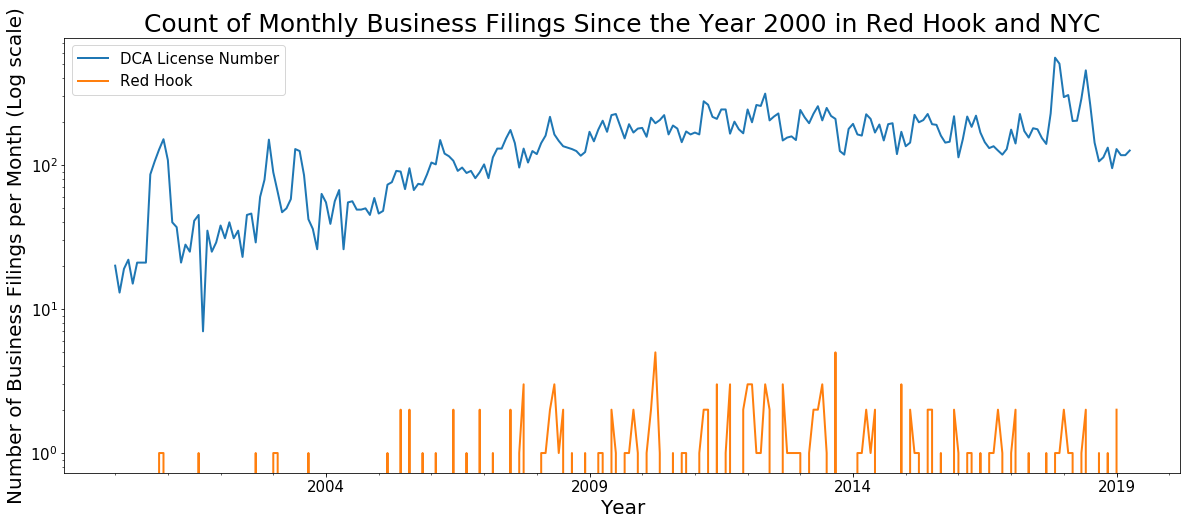

In [50]:
f, ax = plt.subplots(figsize=(20,8))
bk_count[bk_count.index.year>=2000]['DCA License Number'].plot(alpha=1,linewidth=2,ax=ax)
rh_count[rh_count.index.year>=2000]['DCA License Number'].plot(alpha=1,linewidth=2,ax=ax,label='Red Hook')
plt.title("Count of Monthly Business Filings Since the Year 2000 in Red Hook and NYC", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Business Filings per Month (Log scale)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.yscale('log')
plt.show()

## Descriptive stats

This data set is somewhat confusing because it includes the information for vendors across the country who have filed to operate in NYC. So the address information in this data set includes other locations outside NYC. It may be difficult to establish exactly how many business filings are related to Red Hook.

For now, I will use a simple spatial join with our combined Red Hook cesus tracts to get an initial sense of the number of business filings within Red Hook.

In [18]:
# Number of rows missing borough info
print(nyc_filings['Address Borough'].notnull().sum())
print(nyc_filings['Address Borough'].isnull().sum())

113731
70414


In [19]:
# Number of rows missing city info
print(nyc_filings['Address City'].notnull().sum())
print(nyc_filings['Address City'].isnull().sum())

183435
710


In [20]:
# Number of rows missing lat lon
print(nyc_filings['Longitude'].notnull().sum())
print(nyc_filings['Latitude'].isnull().sum())

113622
70523


## For plotting filings by industry

In [21]:
industries = set(nyc_filings['Industry'].values)
industries

{'Amusement Arcade',
 'Amusement Device Permanent',
 'Amusement Device Portable',
 'Amusement Device Temporary',
 'Auction House Premises',
 'Auctioneer',
 'Bingo Game Operator',
 'Booting Company',
 'Cabaret',
 'Car Wash',
 'Catering Establishment',
 'Commercial Lessor',
 'Dealer In Products',
 'Debt Collection Agency',
 'Electronic & Appliance Service',
 'Electronic Cigarette Dealer',
 'Electronics Store',
 'Employment Agency',
 'Games of Chance',
 'Gaming Cafe',
 'Garage',
 'Garage and Parking Lot',
 'General Vendor',
 'General Vendor Distributor',
 'Home Improvement Contractor',
 'Home Improvement Salesperson',
 'Horse Drawn Cab Owner',
 'Horse Drawn Driver',
 'Laundries',
 'Laundry',
 'Laundry Jobber',
 'Locksmith',
 'Locksmith Apprentice',
 'Motion Picture Projectionist',
 'Newsstand',
 'Parking Lot',
 'Pawnbroker',
 'Pedicab Business',
 'Pedicab Driver',
 'Pool or Billiard Room',
 'Process Server Individual',
 'Process Serving Agency',
 'Scale Dealer Repairer',
 'Scrap Metal Pro

# Next steps

* Plot business filing patterns in Red Hook over time
* Deal with missing latitude and longitude